In [1]:
import os
os.chdir("D:/data")  # 切换到 D 盘的 data 目录
print(os.getcwd())

D:\data


In [3]:
import pandas as pd
import os

# Set folder path and filenames
folder_path = "D:/DATA/loc3"
file_names = ["train.csv", "val.csv"]

# Initialize statistics
total_files = 0
only_car_count = 0
only_truck_count = 0
both_vehicle_count = 0
empty_count = 0
single_vehicle_total = 0  # Number of samples where only one of the four fields equals 1

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue

    df = pd.read_csv(file_path)

    # Calculate total count per type
    df["car_total"] = df["car_left"] + df["car_right"]
    df["truck_total"] = df["cv_left"] + df["cv_right"]

    # Classification statistics
    only_car = df[(df["car_total"] > 0) & (df["truck_total"] == 0)].shape[0]
    only_truck = df[(df["truck_total"] > 0) & (df["car_total"] == 0)].shape[0]
    both_vehicle = df[(df["car_total"] > 0) & (df["truck_total"] > 0)].shape[0]
    empty = df[(df["car_total"] == 0) & (df["truck_total"] == 0)].shape[0]

    # Accumulate results
    total_files += df.shape[0]
    only_car_count += only_car
    only_truck_count += only_truck
    both_vehicle_count += both_vehicle
    empty_count += empty

    # Count samples where only one of the four vehicle fields is 1
    vehicle_cols = ["car_left", "car_right", "cv_left", "cv_right"]
    df["vehicle_sum"] = df[vehicle_cols].sum(axis=1)
    single_vehicle_df = df[df["vehicle_sum"] == 1]

    # Save filtered samples to new CSV
    output_path = os.path.join(folder_path, f"single_vehicle_{file_name}")
    single_vehicle_df.to_csv(output_path, index=False)
    print(f"Saved samples with only one vehicle present to: {output_path}")
    
    single_vehicle_total += single_vehicle_df.shape[0]

# Print final statistics
print("\nStatistics:")
print(f"Total number of samples: {total_files}")
print(f"Samples with only cars: {only_car_count}")
print(f"Samples with only trucks: {only_truck_count}")
print(f"Samples with both cars and trucks: {both_vehicle_count}")
print(f"Samples with no vehicles: {empty_count}")
print(f"Samples where only one of car_left/car_right/cv_left/cv_right is 1: {single_vehicle_total}")


Saved samples with only one vehicle present to: D:/DATA/loc3\single_vehicle_train.csv
Saved samples with only one vehicle present to: D:/DATA/loc3\single_vehicle_val.csv

Statistics:
Total number of samples: 8855
Samples with only cars: 7583
Samples with only trucks: 101
Samples with both cars and trucks: 999
Samples with no vehicles: 172
Samples where only one of car_left/car_right/cv_left/cv_right is 1: 1089


In [4]:
import pandas as pd
import os
import librosa
import numpy as np

# Read CSV file
csv_path = "D:/DATA/loc3/single_vehicle_train.csv"  # or single_vehicle_val.csv
prefix = "D:/DATA/loc3/"
df = pd.read_csv(csv_path)
df["path"] = df["path"].apply(lambda x: prefix + x if not x.startswith(prefix) else x)

# Set analysis parameters
frame_duration = 3.0  # Duration of each segment (in seconds)
sr_target = 16000     # Target sampling rate

# Store results
analysis_results = []

for idx, row in df.iterrows():
    audio_path = row['path']
    
    if not os.path.exists(audio_path):
        print(f"File does not exist: {audio_path}")
        continue

    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=sr_target)
        duration = librosa.get_duration(y=y, sr=sr)

        # Compute frame length and total number of segments
        frame_length = int(sr * frame_duration)
        total_frames = len(y) // frame_length

        # Extract features per segment (e.g., energy and mean amplitude)
        for i in range(total_frames):
            start = i * frame_length
            end = start + frame_length
            frame = y[start:end]

            if len(frame) < frame_length:
                continue  # Skip short last segment

            energy = np.sum(frame ** 2)
            mean_amp = np.mean(np.abs(frame))

            analysis_results.append({
                "original_index": idx,
                "audio_path": audio_path,
                "segment": i,
                "duration": duration,
                "energy": energy,
                "mean_amplitude": mean_amp
            })

    except Exception as e:
        print(f"Failed to process audio {audio_path}: {e}")

# Save analysis results
result_df = pd.DataFrame(analysis_results)
output_csv = csv_path.replace(".csv", "_analysis.csv")
result_df.to_csv(output_csv, index=False)
print(f"Audio analysis results saved to: {output_csv}")


Audio analysis results saved to: D:/DATA/loc3/single_vehicle_train_analysis.csv


D:\aconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


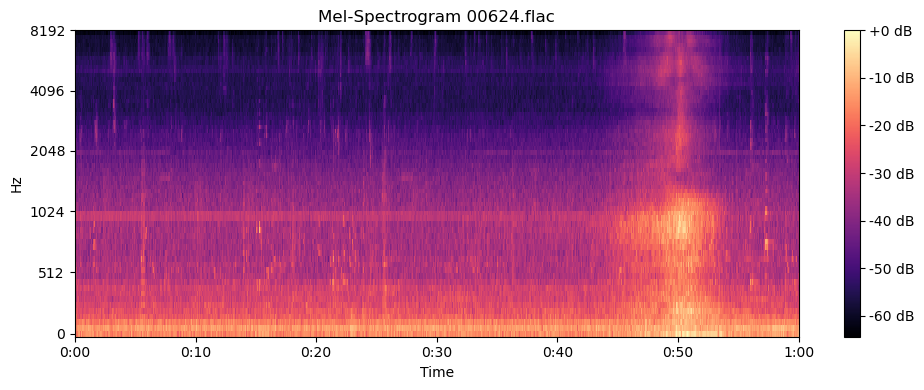

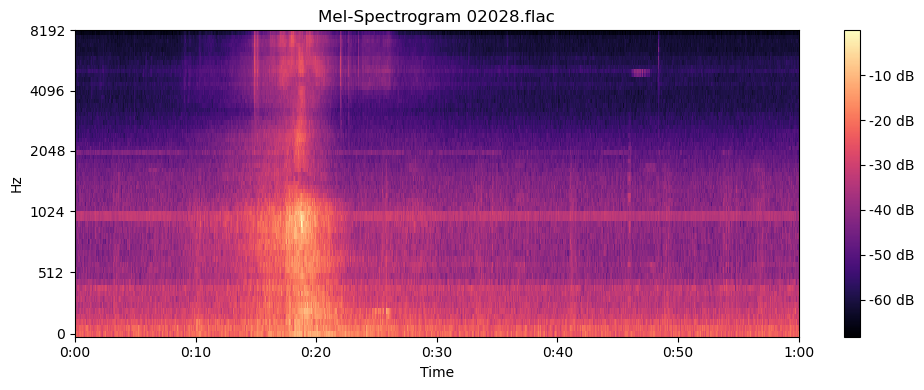

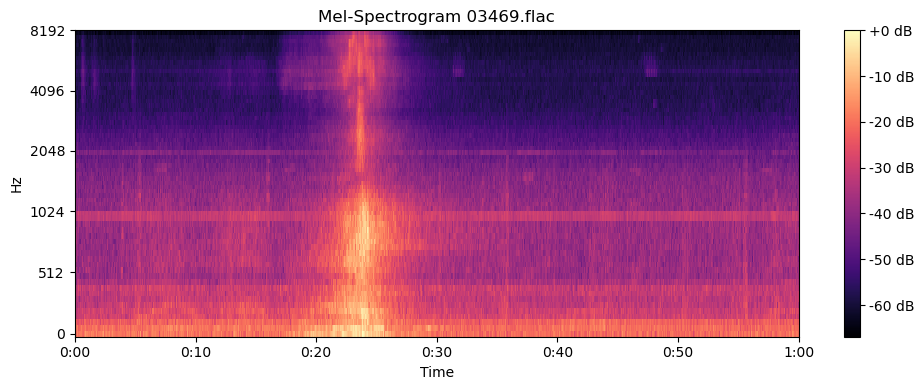

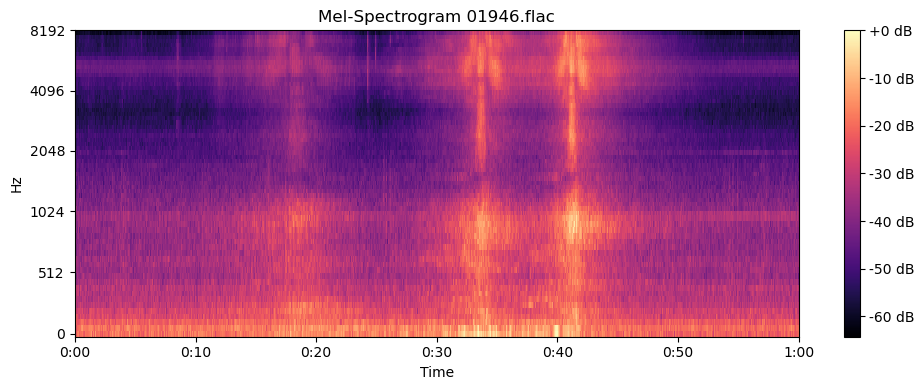

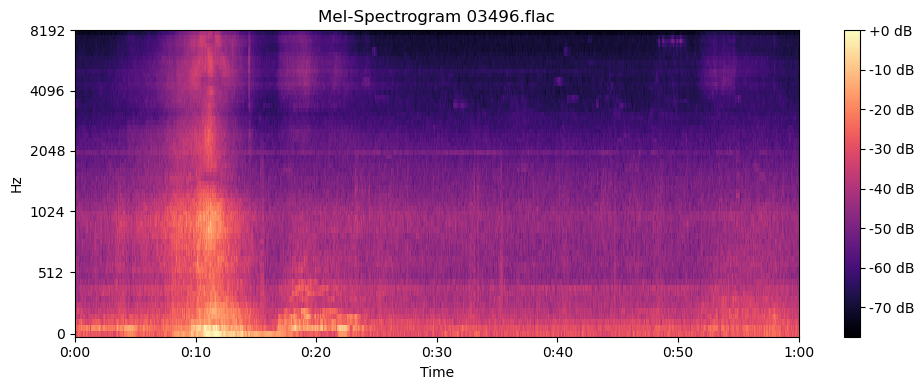

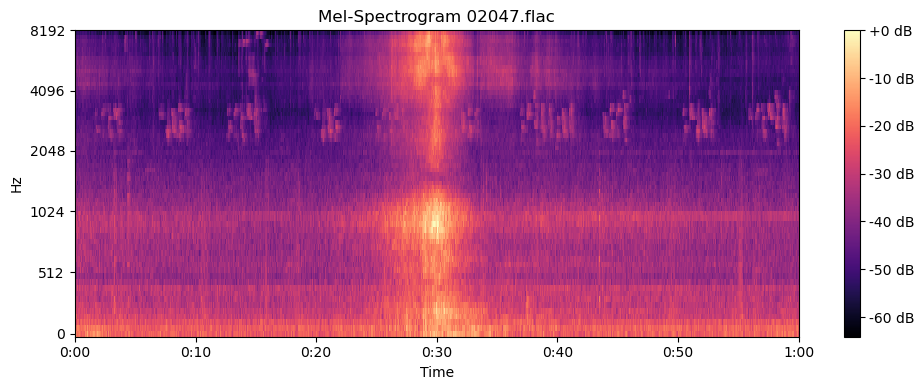

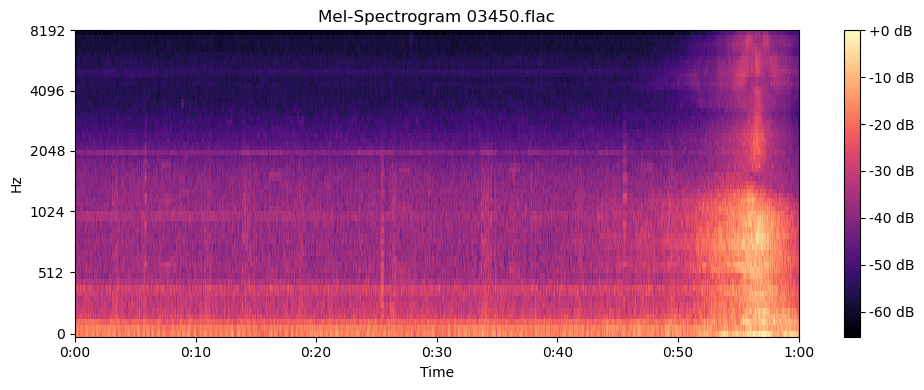

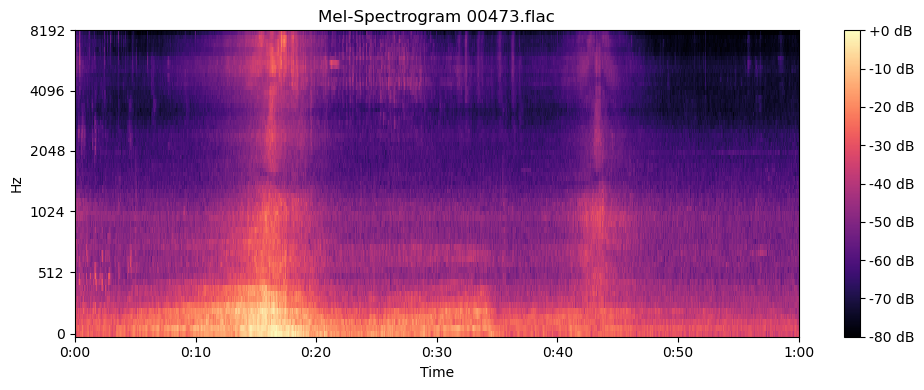

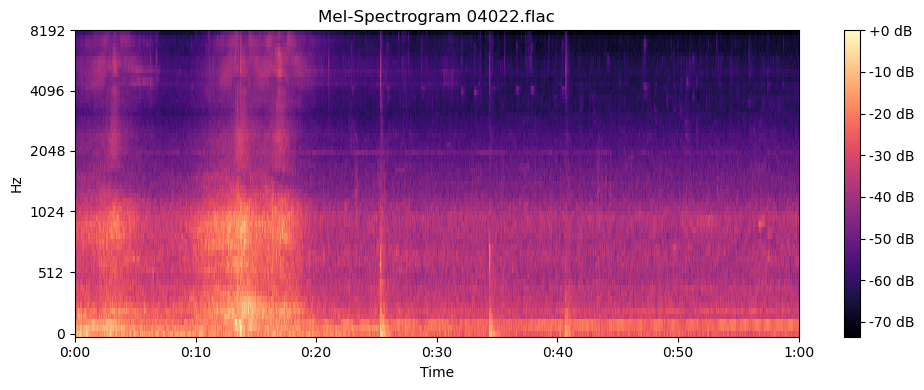

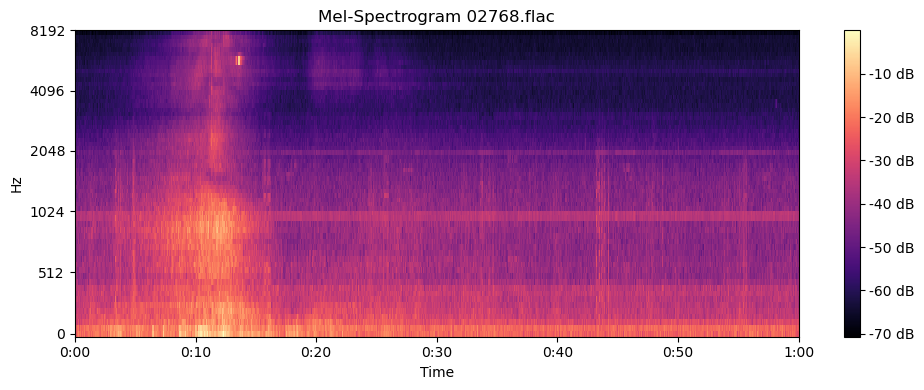

In [1]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Load the analysis result CSV
csv_path = "D:/DATA/loc3/single_vehicle_train_analysis.csv"
df = pd.read_csv(csv_path)

# Add prefix to audio paths if not already present
prefix = "D:/DATA/loc3/"
df["audio_path"] = df["audio_path"].apply(lambda x: prefix + x if not x.startswith(prefix) else x)

# Randomly select 10 unique audio paths
unique_paths = df["audio_path"].unique()
selected_paths = random.sample(list(unique_paths), 10)

# Mel-spectrogram parameters
sr_target = 16000
n_mels = 64

# Plot Mel-spectrogram for each audio file
for idx, path in enumerate(selected_paths):
    if not os.path.exists(path):
        print(f"File does not exist: {path}")
        continue

    try:
        y, sr = librosa.load(path, sr=sr_target)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Show spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel-Spectrogram {os.path.basename(path)}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to process: {path}: {e}")
s

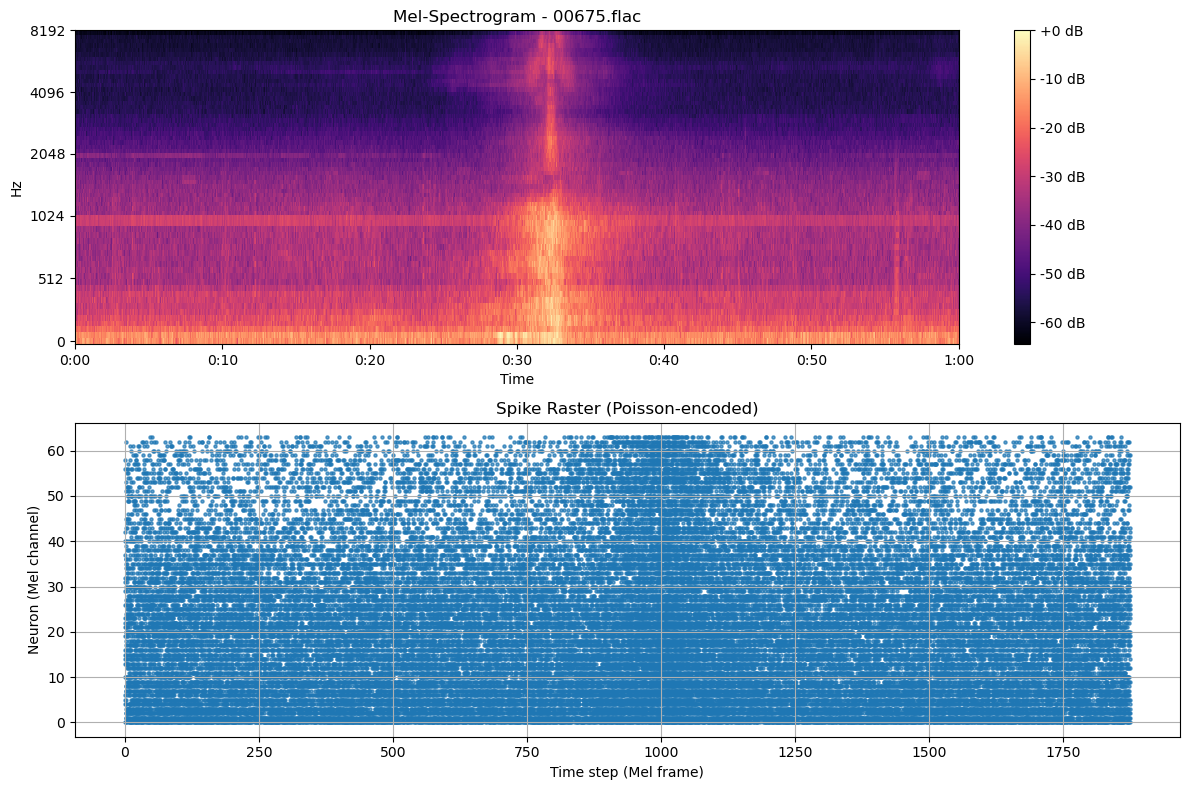

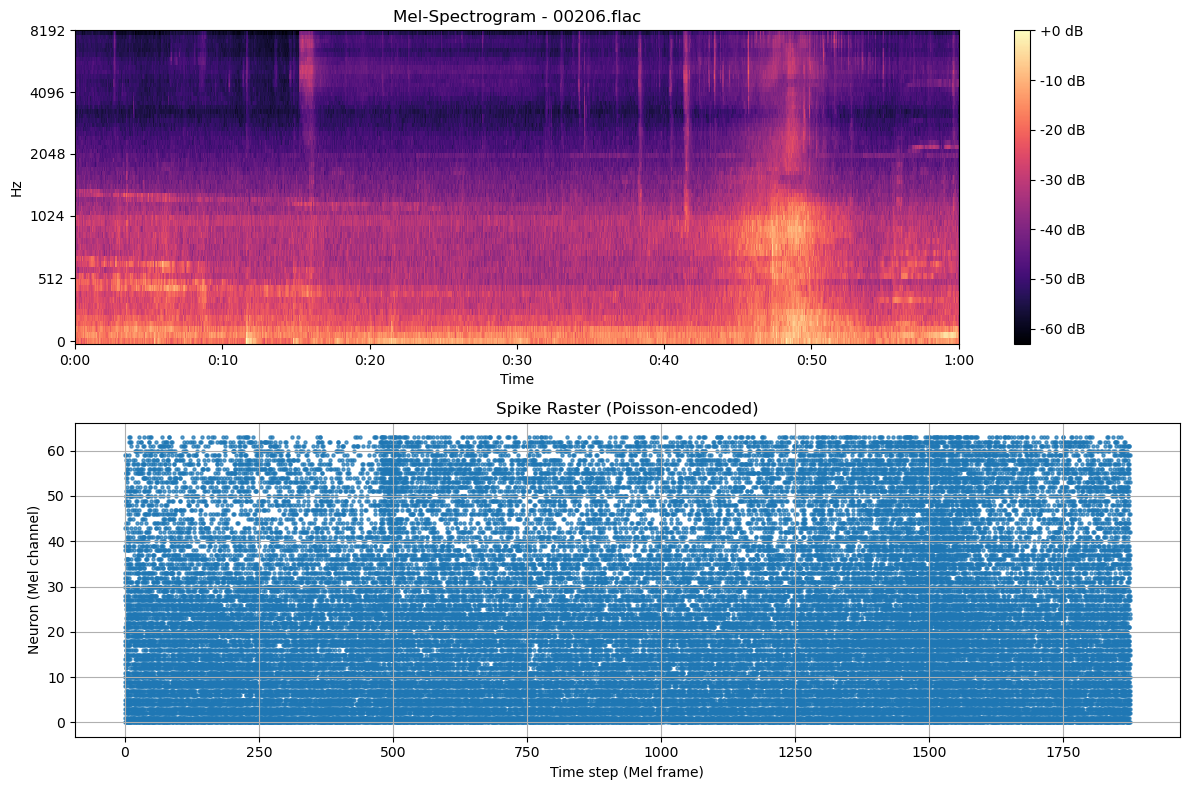

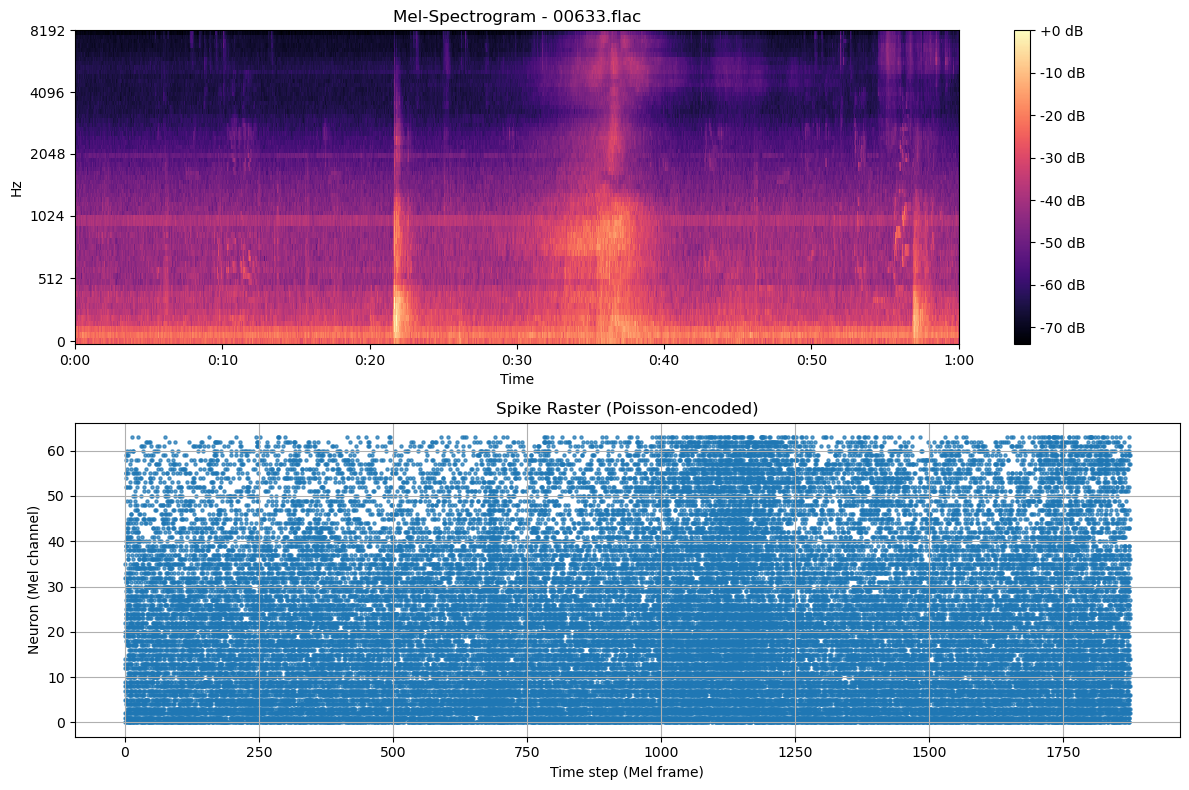

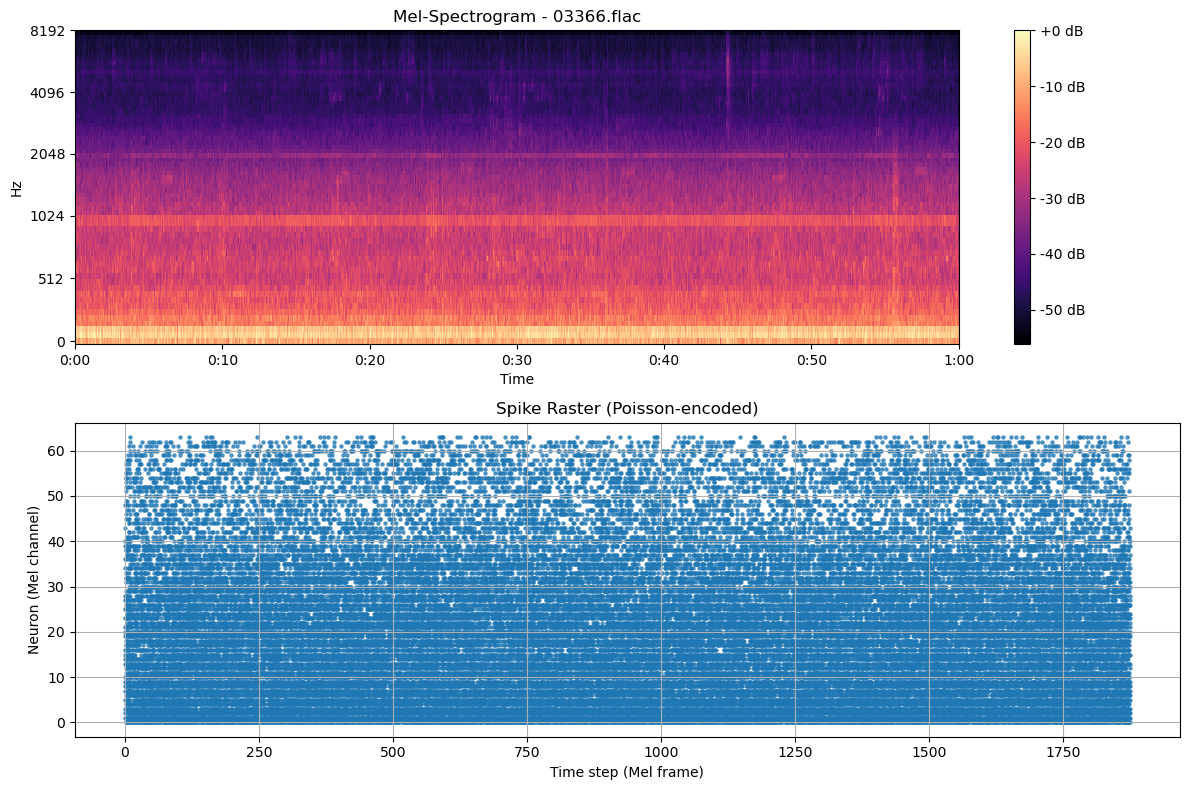

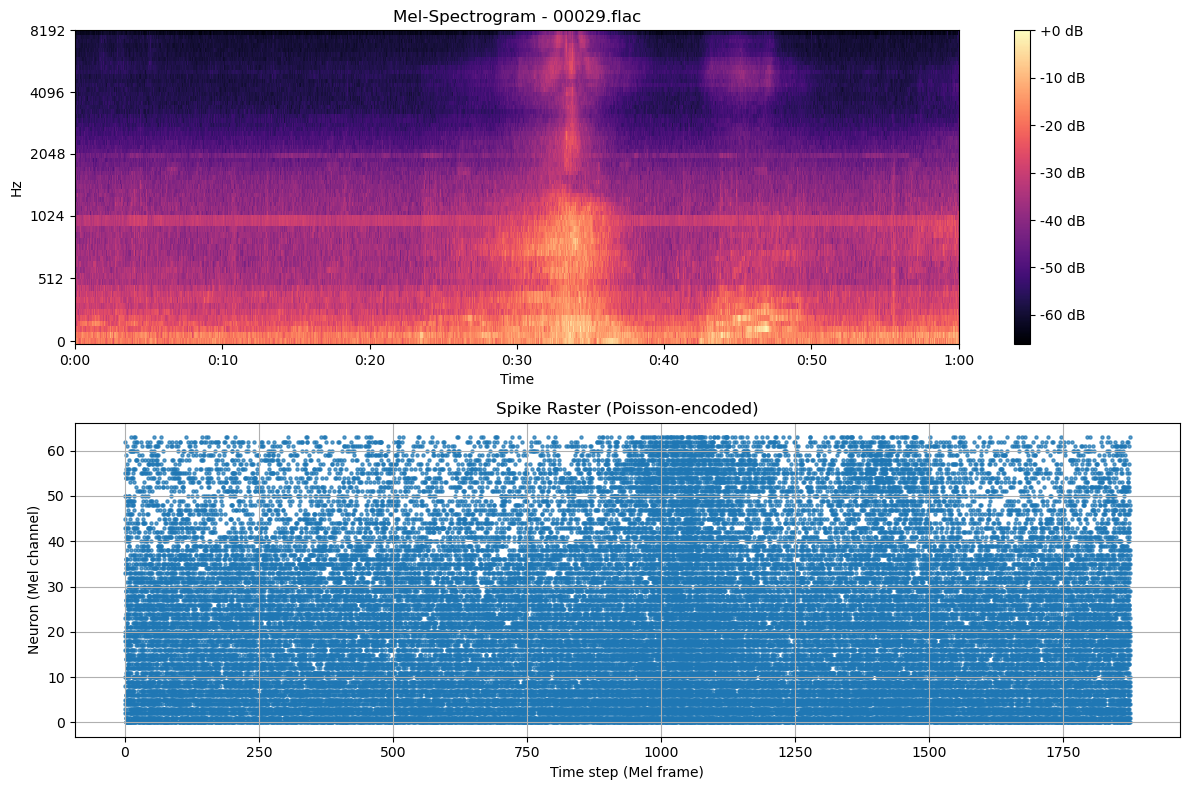

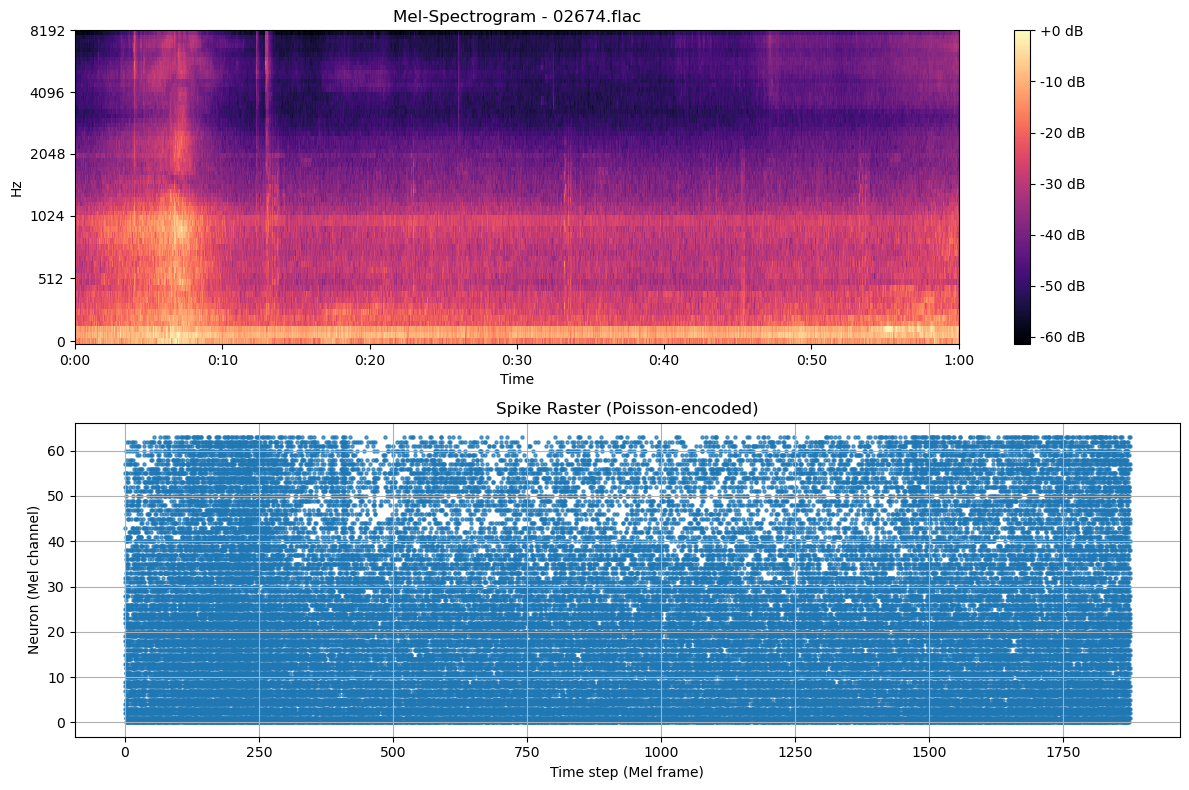

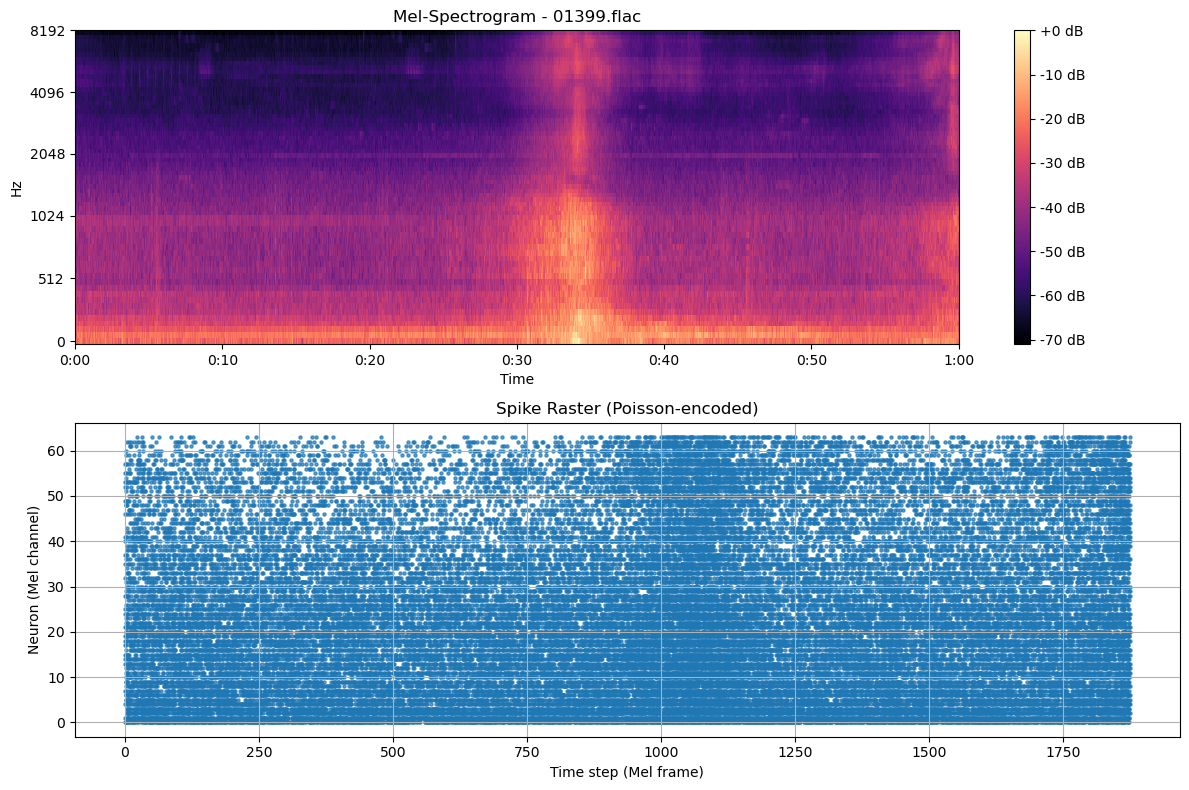

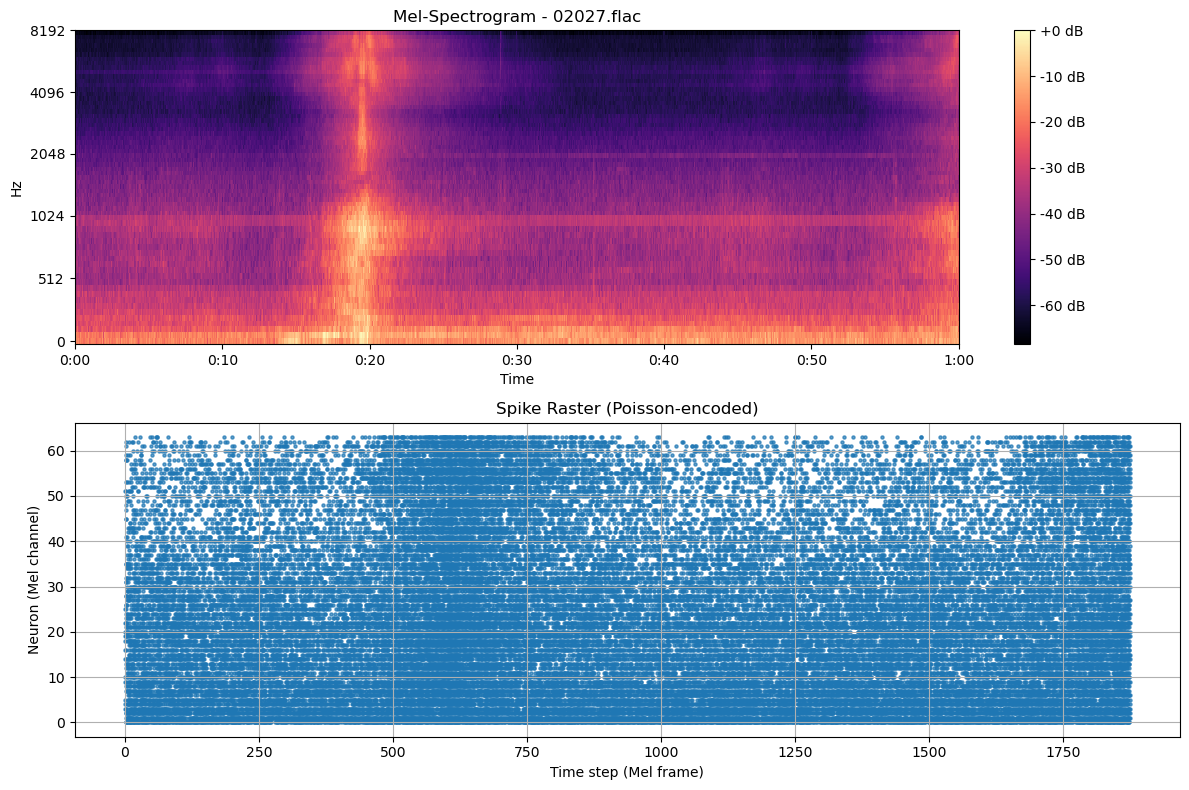

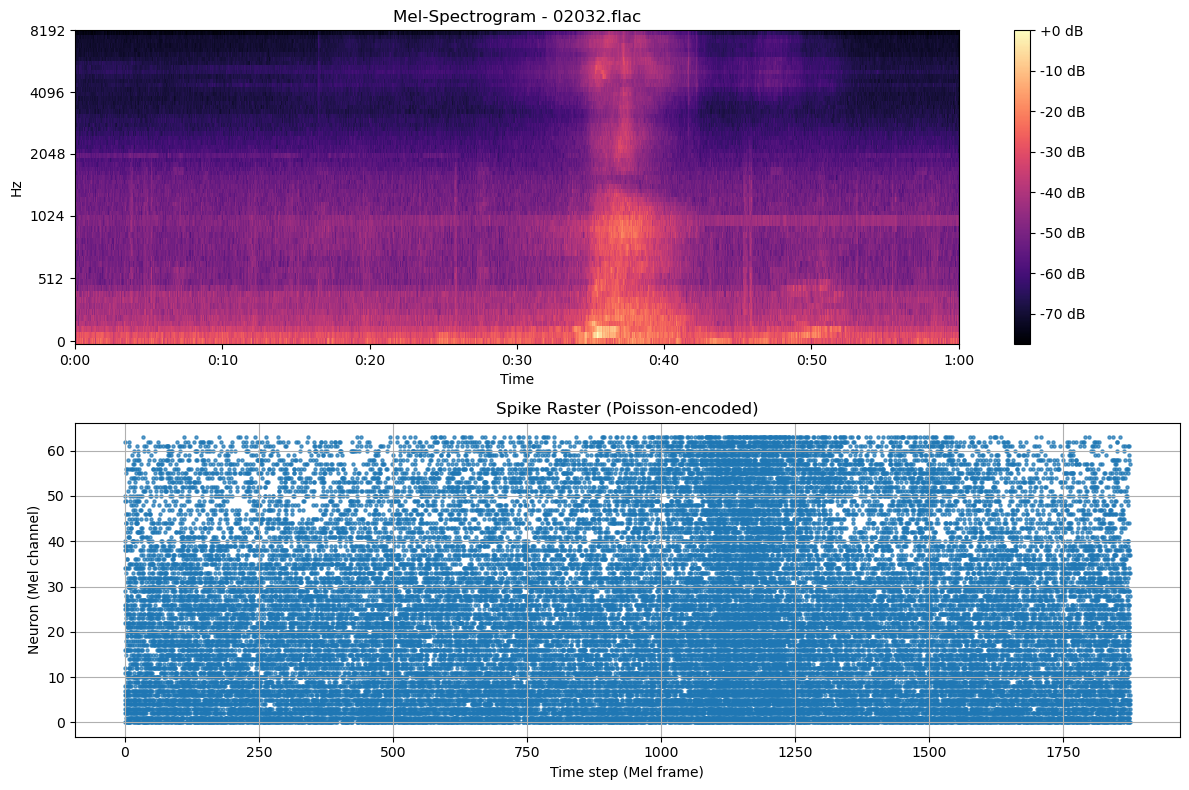

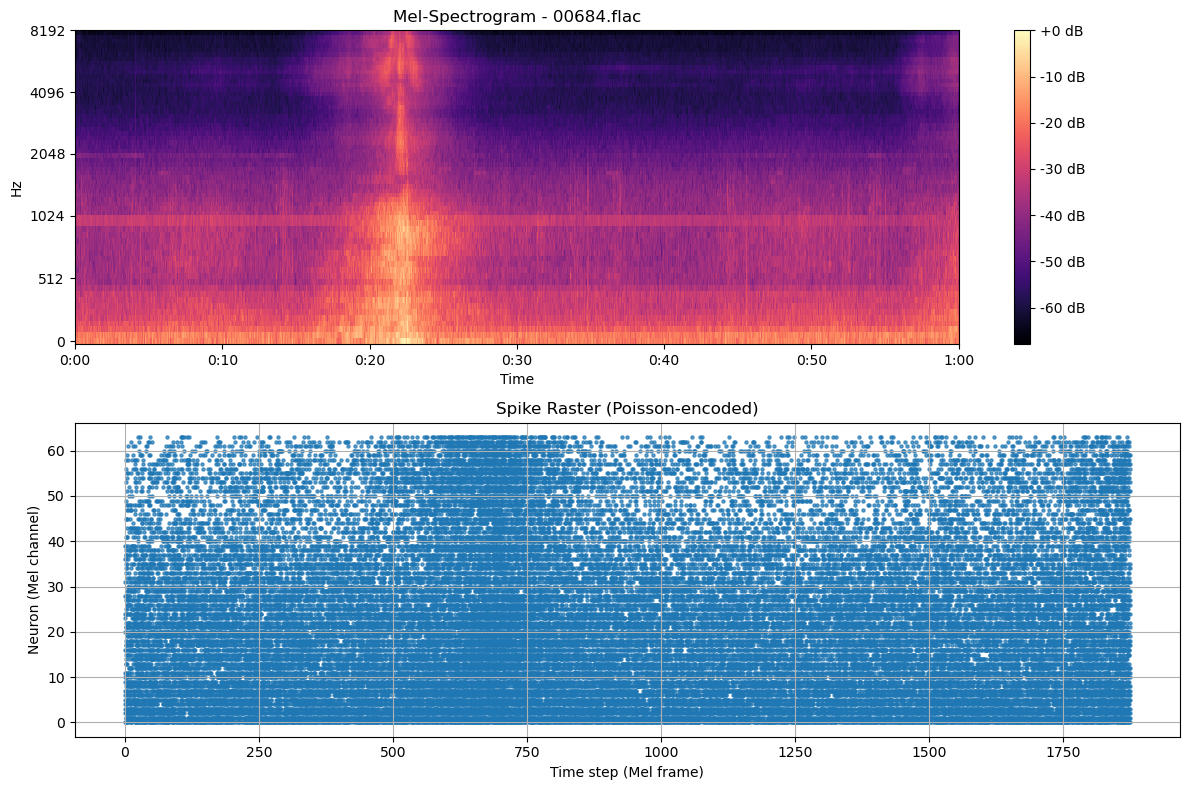

In [4]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Load the analysis result CSV
csv_path = "D:/DATA/loc3/single_vehicle_train_analysis.csv"
df = pd.read_csv(csv_path)

# Add prefix to audio paths if not already present
prefix = "D:/DATA/loc3/"
df["audio_path"] = df["audio_path"].apply(lambda x: prefix + x if not x.startswith(prefix) else x)

# Randomly select 10 unique audio paths
unique_paths = df["audio_path"].unique()
selected_paths = random.sample(list(unique_paths), 10)

# Parameters
sr_target = 16000
n_mels = 64
hop_length = 512
encoding = "poisson"
np.random.seed(42)

def mel_to_spikes(S_norm, encoding="poisson", max_rate=50):
    spike_events = []  # (time, channel)
    T = S_norm.shape[1]
    C = S_norm.shape[0]

    for t in range(T):
        for c in range(C):
            value = S_norm[c, t]
            if encoding == "poisson":
                if np.random.rand() < value:
                    spike_events.append((t, c))
            elif encoding == "rate":
                spike_events += [(t, c)] * int(value * max_rate)
            elif encoding == "threshold":
                if value > 0.5:
                    spike_events.append((t, c))
    return spike_events

# Process and plot
for idx, path in enumerate(selected_paths):
    if not os.path.exists(path):
        print(f"File does not exist: {path}")
        continue

    try:
        # --- 1. Load audio and compute Mel-spectrogram ---
        y, sr = librosa.load(path, sr=sr_target)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
        S_dB = librosa.power_to_db(S, ref=np.max)
        S_norm = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())  # normalize to [0, 1]

        # --- 2. Generate spikes from mel spectrogram ---
        spike_events = mel_to_spikes(S_norm, encoding="poisson")

        # --- 3. Plot Mel-Spectrogram ---
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', hop_length=hop_length)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel-Spectrogram - {os.path.basename(path)}")

        # --- 4. Plot spike raster ---
        if spike_events:
            t_list, c_list = zip(*spike_events)
            plt.subplot(2, 1, 2)
            plt.scatter(t_list, c_list, s=5, alpha=0.7)
            plt.title("Spike Raster (Poisson-encoded)")
            plt.xlabel("Time step (Mel frame)")
            plt.ylabel("Neuron (Mel channel)")
            plt.grid(True)
        else:
            plt.subplot(2, 1, 2)
            plt.text(0.5, 0.5, "No spikes generated", ha="center", va="center")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to process: {path}: {e}")
